# Event detection with Recurrent Neural Networks - Part 1

In this fifth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will use different types of Recurrent Neural Networks to detect events in noisy seismic recordings. This is a very important task in both Global and Applied Seismology: it can used in the former case to automatically analyse thousands seimograms recorded in Global Seismological Networks and extract signals associated to Earthquake activities, whilst it is relevant to the latter case in the context of Microseismic monitoring.

Whilst different approaches exist to accomplish this task, here we will train a network with synthetically generated seismograms such that we can also have access to ground truth labels. Moreover, whilst this problem can be framed as a regression task where we could try to estimate the start time and duration of an event, here we prefer to cast it as a segmentation task where the output is a binary time series of the same lenght of the input data where we wish to predict for each time sample if this is part of an event or not.

This notebook is organized as follows:

- synthetic data generation;
- training using a LSTM network with standard BCE loss;
- training using a LSTM network with a weighted BCE loss (aimed at compensating the fact that we have unbalanced labels - most time steps are not associated to an event);
- training using a Bidirectional-LSTM network with the same weighted BCE loss.

Moreover, whilst up until now we have been able to train our DNNs on a single CPU, this notebook serves also as an introduction to GPU training in PyTorch.

This notebook has been co-authored by [C. Birnie](http://cebirnie92.github.io) and it is based on the following paper:

C. Birnie and F. Hansteen, Bidirectional recurrent neural networks for seismic event detection, Geophysics, 2022 - [link](https://library.seg.org/doi/abs/10.1190/geo2020-0806.1).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io
import os
import glob
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.metrics import accuracy_score, classification_report

import dataset as dc
from model import *
from train import *
from utils import *

Let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
set_seed(40)

True

Finally we set a flag that chooses whether we want to train our networks or load pre-trained ones. 

In this lab we will first train our networks and later simply load them if we want to just do some predictions on new data.

In [4]:
loadmodel = False
modelsdir = './'

## Data creation

To begin with we need to create a large variety of training data. Each training pair will be composed of a seismic trace and a trigger trace, where the latter is equal 1 in correspondance of the seismic event and 0 elsewhere.

The seismic trace is created as follows:

$$
s(t) = a * w(t;f) * r(t;t_0) + n(t, SNR)
$$

where the central frequency of the wavelet $f$, the time of the event $t_0$, and $SNR$ are randomly chosen for each trace. Moreover, some of the traces contain only noise, this is driven by the $a$ parameter. 

In [5]:
# Input paramters
nt = 500 # number of time samples
dt = 0.002 # time sampling
#SNR = [5., 10., -1., 4.] # signal to noise ratio paramters (min, max, skewness, mean) - low noise level
SNR = [2., 8., 4., 3.] # signal to noise ratio paramters (min, max, skewness, mean) - high noise level
noise_freq = [2, 40] # min and max frequency of noise
wavelet_freq = [20, 30] # min and max frequency of wavelet

ntraining = 500 # number of training samples
ntest = 50 # number of test samples

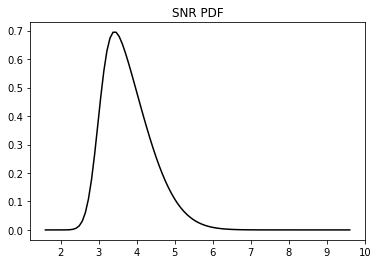

In [6]:
# Display SNR
plt.plot(*dc.pdf_snr(*SNR), 'k')
plt.title('SNR PDF');

In [7]:
# Create data
traindata = [dc.create_data(nt=nt, dt=dt,
                            snrparams=SNR, 
                            freqwav=wavelet_freq, 
                            freqbp=noise_freq, 
                            signal=True) 
             for i in tqdm(range(ntraining))]

testdata = [dc.create_data(nt=nt, dt=dt,
                           snrparams=SNR, 
                           freqwav=wavelet_freq, 
                           freqbp=noise_freq, 
                           signal=True) 
            for i in tqdm(range(ntest))]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
train_data_X = np.zeros([ntraining, nt, 1])
train_data_y = np.zeros([ntraining, nt])

for i, d in enumerate(traindata):  
    train_data_X[i, :, 0] = d['synthetic']
    train_data_y[i, :] = d['labels']

In [9]:
test_data_X = np.zeros([ntest, nt, 1])
test_data_y = np.zeros([ntest, nt])

for i, d in enumerate(testdata):  
    test_data_X[i, :, 0] = d['synthetic']
    test_data_y[i, :] = d['labels']

In [10]:
# percentage of 0 labels over 1 labels
scaling = np.round(np.mean([(nt-np.sum(traindata[i]['labels']))/np.sum(traindata[i]['labels']) for i in range(ntraining)]))
scaling

11.0

Let's take a look at the data we are going to work with

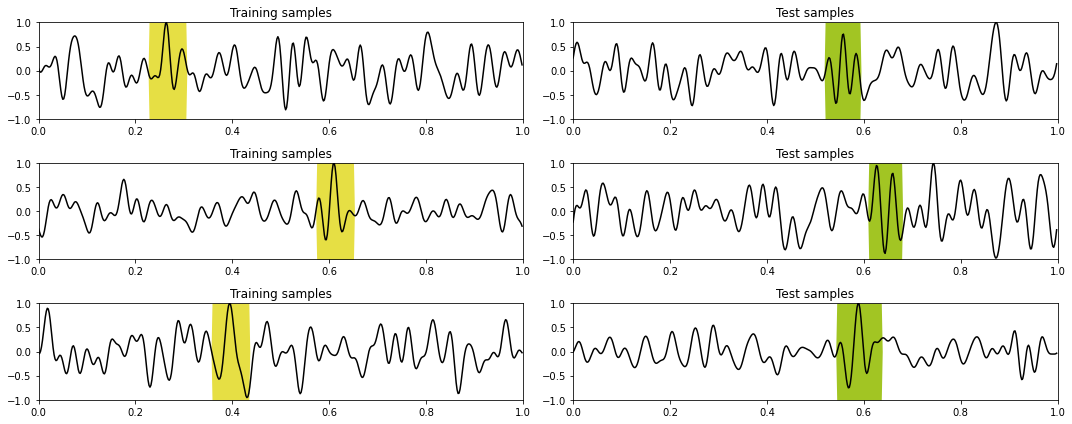

In [11]:
nplot = 3
plotting(train_data_X, train_data_y, test_data_X, test_data_y, 
         'Training samples', 'Test samples', dt=dt, nplot=3)

## Training

We are ready to prepare the training and test data

In [12]:
# Define Train Set
X_train = torch.from_numpy(train_data_X).float()
y_train = torch.from_numpy(train_data_y).float()

train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_test = torch.from_numpy(test_data_X).float()
y_test = torch.from_numpy(test_data_y).float()

test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### LSTM with Standard BCE

Epoch 0, Training Loss 0.673, Training Accuracy 0.918, Test Loss 0.662, Test Accuracy 0.918
Epoch 10, Training Loss 0.294, Training Accuracy 0.918, Test Loss 0.294, Test Accuracy 0.918
Epoch 20, Training Loss 0.290, Training Accuracy 0.918, Test Loss 0.290, Test Accuracy 0.918
Epoch 30, Training Loss 0.288, Training Accuracy 0.918, Test Loss 0.288, Test Accuracy 0.918
Epoch 40, Training Loss 0.277, Training Accuracy 0.918, Test Loss 0.278, Test Accuracy 0.918
Epoch 50, Training Loss 0.278, Training Accuracy 0.918, Test Loss 0.278, Test Accuracy 0.918
Epoch 60, Training Loss 0.262, Training Accuracy 0.918, Test Loss 0.263, Test Accuracy 0.918
Epoch 70, Training Loss 0.248, Training Accuracy 0.918, Test Loss 0.241, Test Accuracy 0.918
Epoch 80, Training Loss 0.239, Training Accuracy 0.918, Test Loss 0.235, Test Accuracy 0.918
Epoch 90, Training Loss 0.229, Training Accuracy 0.918, Test Loss 0.226, Test Accuracy 0.918
Best epoch: 0, Valid accuracy: 0.92


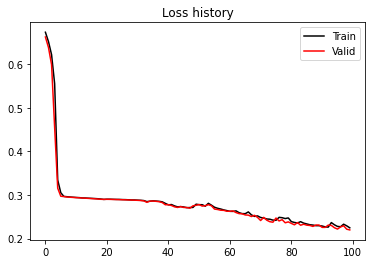

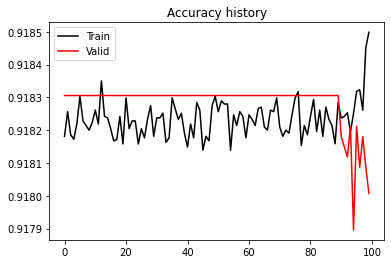

In [13]:
model = 'lstm_bce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network = LSTMNetwork(1, 200, 1)
    network.to(device)
    
    bce_loss = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(network.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network, bce_loss, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network = LSTMNetwork(1, 200, 1)
network.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network.to(device)
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

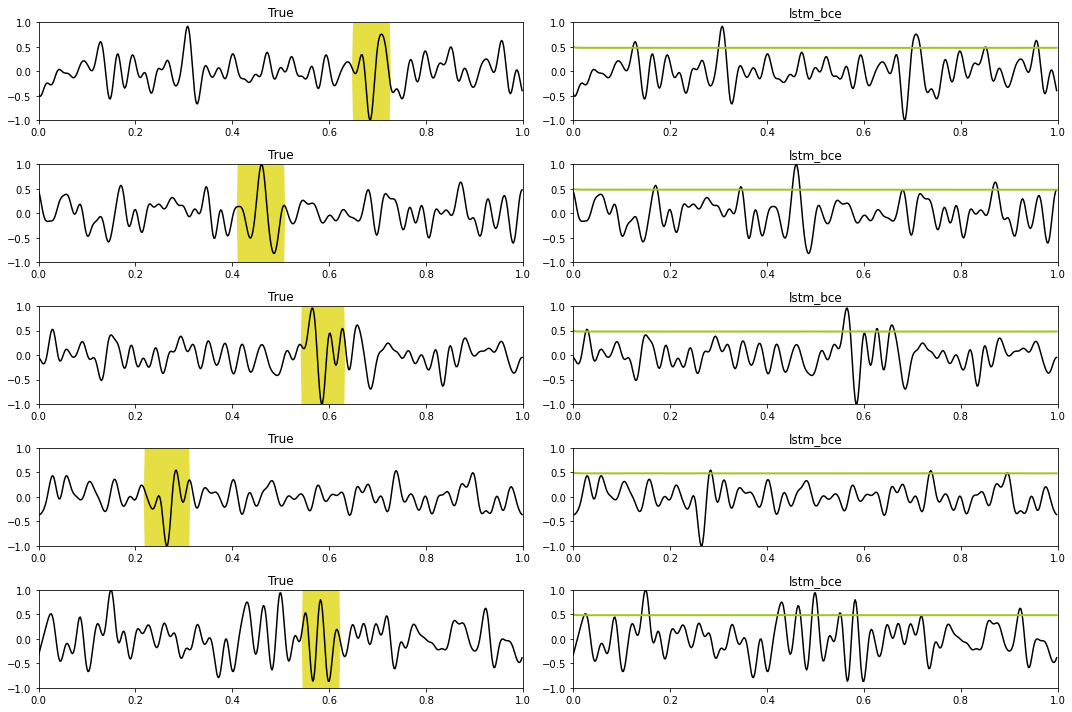

In [14]:
# Prediction train
X, y = next(iter(train_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

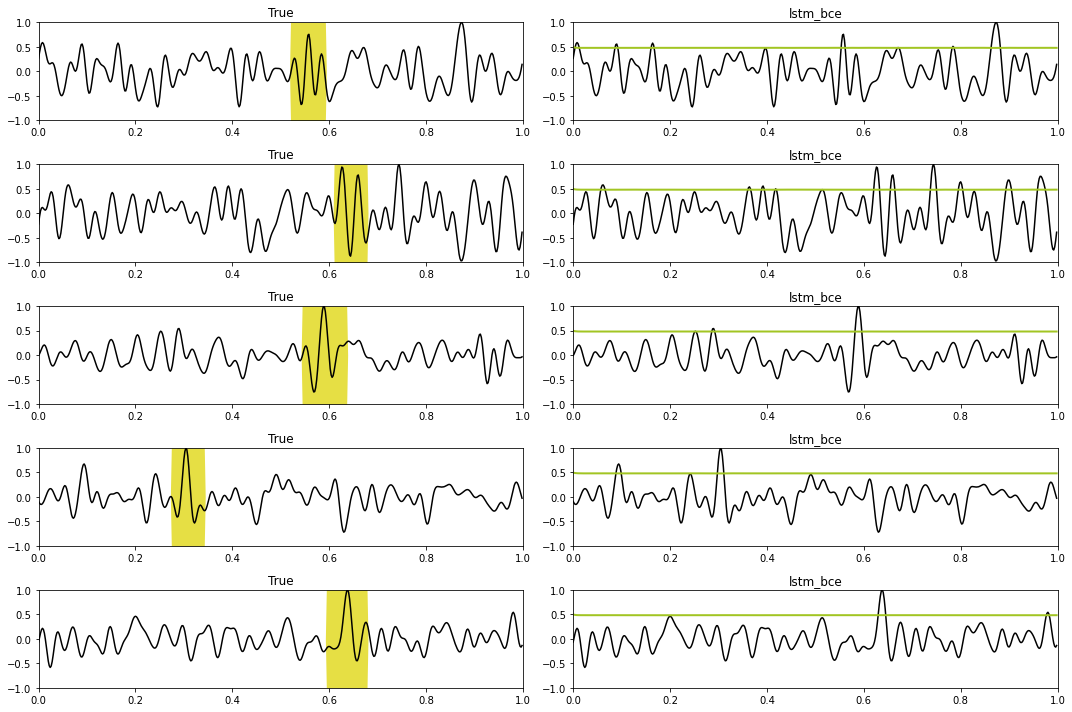

In [15]:
# Prediction test
X, y = next(iter(test_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

### LSTM with Weighted BCE

Epoch 0, Training Loss 1.261, Training Accuracy 0.918, Test Loss 1.259, Test Accuracy 0.918
Epoch 10, Training Loss 1.220, Training Accuracy 0.662, Test Loss 1.209, Test Accuracy 0.394
Epoch 20, Training Loss 0.945, Training Accuracy 0.871, Test Loss 0.911, Test Accuracy 0.900
Epoch 30, Training Loss 0.827, Training Accuracy 0.853, Test Loss 0.794, Test Accuracy 0.834
Epoch 40, Training Loss 0.773, Training Accuracy 0.874, Test Loss 0.745, Test Accuracy 0.871
Epoch 50, Training Loss 0.777, Training Accuracy 0.844, Test Loss 0.728, Test Accuracy 0.715
Epoch 60, Training Loss 0.800, Training Accuracy 0.797, Test Loss 0.746, Test Accuracy 0.909
Epoch 70, Training Loss 0.766, Training Accuracy 0.808, Test Loss 0.745, Test Accuracy 0.866
Epoch 80, Training Loss 0.751, Training Accuracy 0.840, Test Loss 0.712, Test Accuracy 0.791
Epoch 90, Training Loss 0.725, Training Accuracy 0.862, Test Loss 0.706, Test Accuracy 0.847
Best epoch: 45, Valid accuracy: 0.92


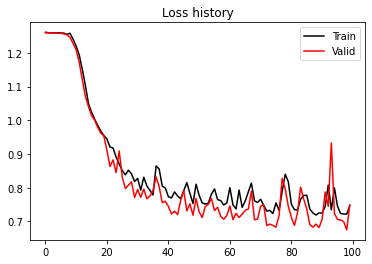

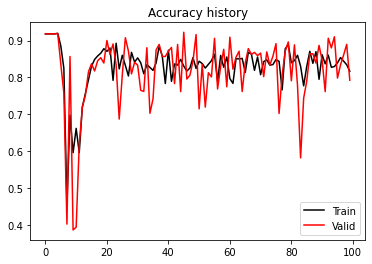

In [16]:
model = 'lstm_weightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_w = LSTMNetwork(1, 200, 1)
    network_w.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_w.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_w, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network_w = LSTMNetwork(1, 200, 1)
network_w.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network_w.to(device)
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

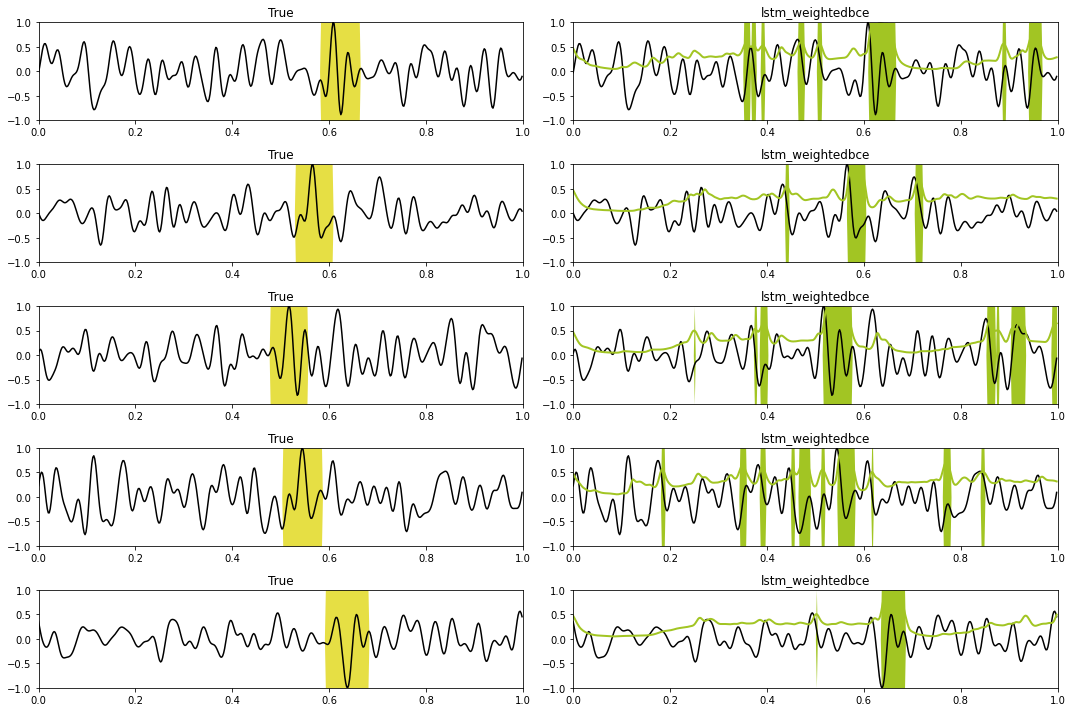

In [17]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_w, X, y, model, device, dt=dt, nplot=5)

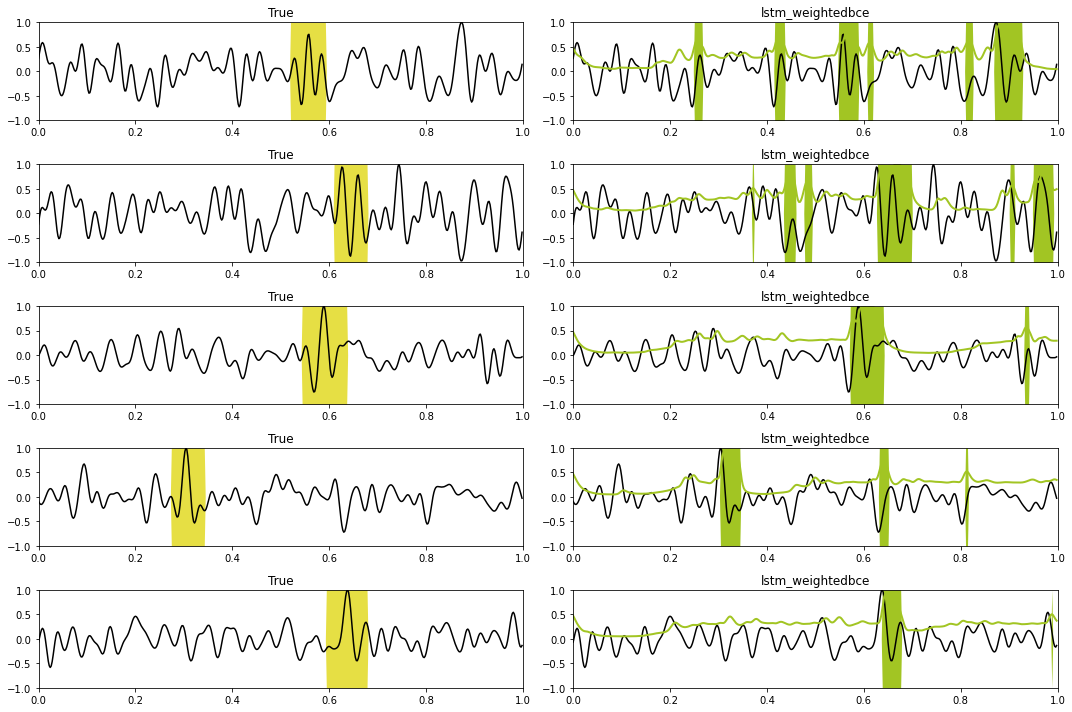

In [18]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_w, X, y, model, device, dt=dt, nplot=5)

### LSTM with strongly Weighted BCE

Epoch 0, Training Loss 1.373, Training Accuracy 0.571, Test Loss 1.371, Test Accuracy 0.084
Epoch 10, Training Loss 1.363, Training Accuracy 0.089, Test Loss 1.363, Test Accuracy 0.089
Epoch 20, Training Loss 1.356, Training Accuracy 0.082, Test Loss 1.354, Test Accuracy 0.082
Epoch 30, Training Loss 1.331, Training Accuracy 0.084, Test Loss 1.334, Test Accuracy 0.084
Epoch 40, Training Loss 1.248, Training Accuracy 0.338, Test Loss 1.237, Test Accuracy 0.396
Epoch 50, Training Loss 1.040, Training Accuracy 0.843, Test Loss 1.039, Test Accuracy 0.826
Epoch 60, Training Loss 1.018, Training Accuracy 0.853, Test Loss 1.004, Test Accuracy 0.843
Epoch 70, Training Loss 0.997, Training Accuracy 0.859, Test Loss 0.981, Test Accuracy 0.852
Epoch 80, Training Loss 0.862, Training Accuracy 0.830, Test Loss 0.844, Test Accuracy 0.647
Epoch 90, Training Loss 0.824, Training Accuracy 0.781, Test Loss 0.773, Test Accuracy 0.697
Best epoch: 83, Valid accuracy: 0.92


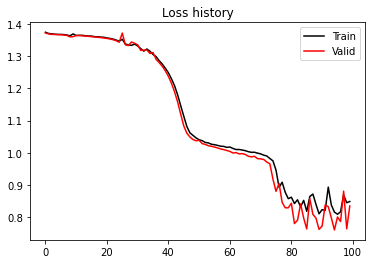

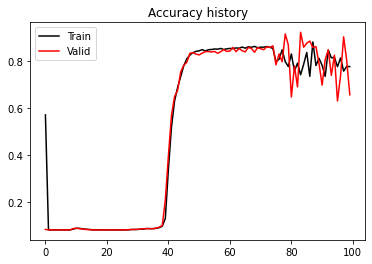

In [19]:
model = 'lstm_strongweightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_w1 = LSTMNetwork(1, 200, 1)
    network_w1.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling+2, ]).to(device))
    optim = torch.optim.Adam(network_w1.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_w1, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network_w1 = LSTMNetwork(1, 200, 1)
network_w1.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network_w1.to(device)

print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

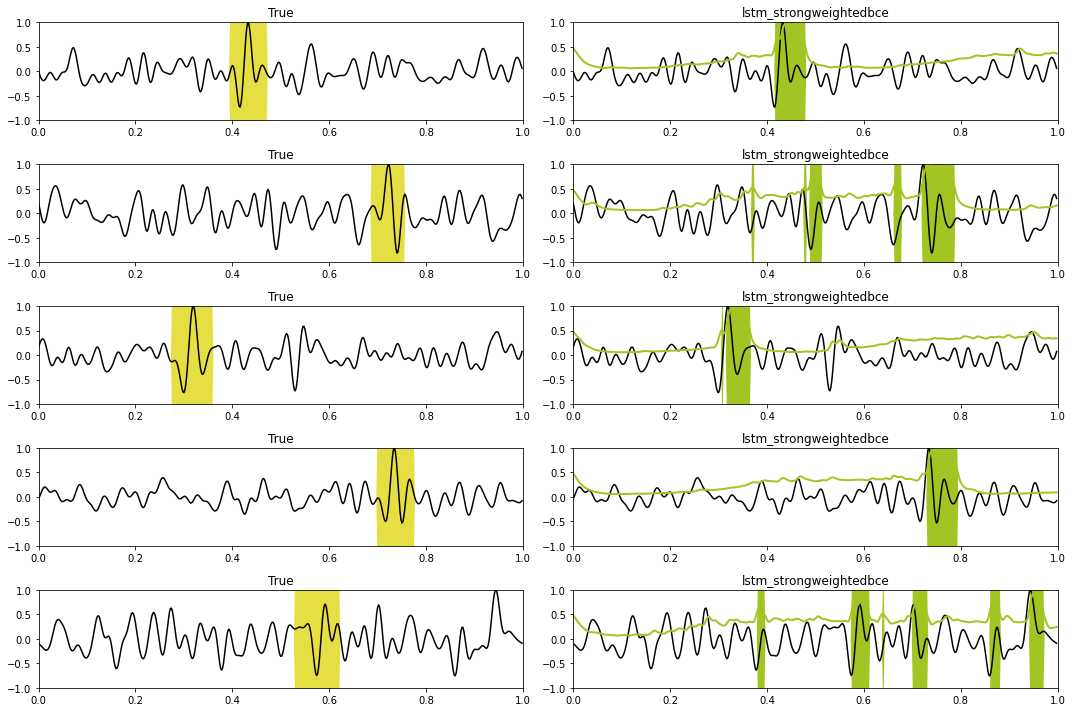

In [20]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_w1, X, y, model, device, dt=dt, nplot=5)

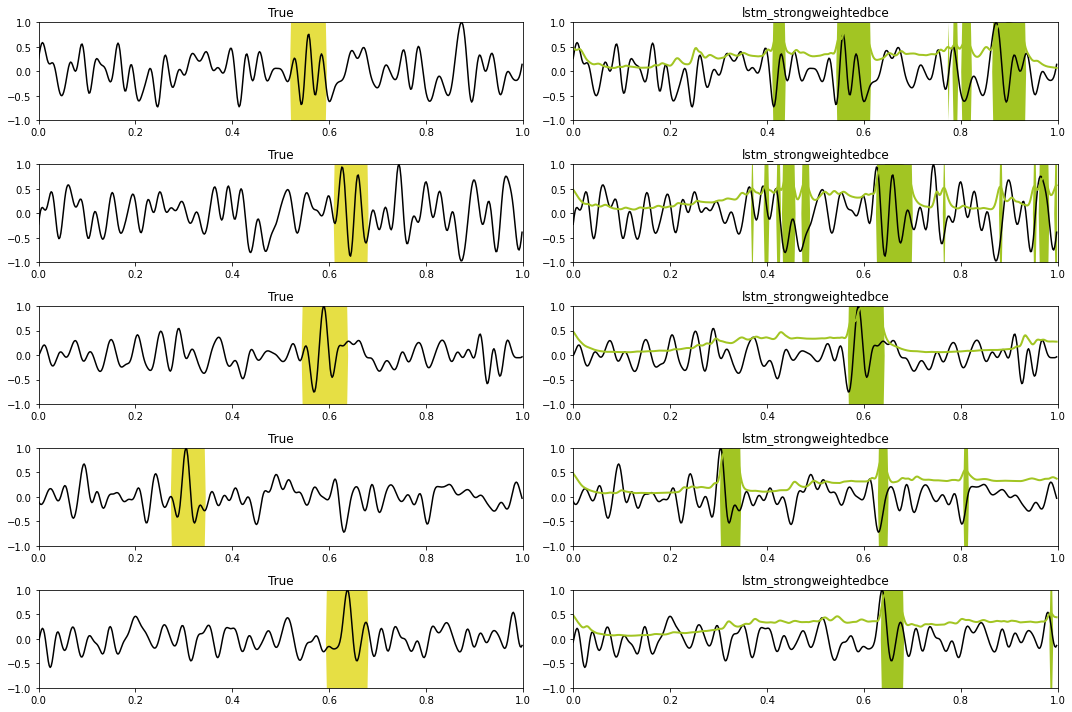

In [21]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_w1, X, y, model, device, dt=dt, nplot=5)

### BidirLSTM

Epoch 0, Training Loss 1.260, Training Accuracy 0.402, Test Loss 1.259, Test Accuracy 0.918
Epoch 10, Training Loss 1.241, Training Accuracy 0.865, Test Loss 1.240, Test Accuracy 0.849
Epoch 20, Training Loss 0.996, Training Accuracy 0.774, Test Loss 0.989, Test Accuracy 0.742
Epoch 30, Training Loss 0.528, Training Accuracy 0.900, Test Loss 0.490, Test Accuracy 0.896
Epoch 40, Training Loss 0.388, Training Accuracy 0.925, Test Loss 0.373, Test Accuracy 0.920
Epoch 50, Training Loss 0.338, Training Accuracy 0.937, Test Loss 0.307, Test Accuracy 0.939
Epoch 60, Training Loss 0.321, Training Accuracy 0.939, Test Loss 0.297, Test Accuracy 0.943
Epoch 70, Training Loss 0.306, Training Accuracy 0.942, Test Loss 0.301, Test Accuracy 0.943
Epoch 80, Training Loss 0.304, Training Accuracy 0.942, Test Loss 0.282, Test Accuracy 0.957
Epoch 90, Training Loss 0.289, Training Accuracy 0.945, Test Loss 0.291, Test Accuracy 0.942
Best epoch: 98, Valid accuracy: 0.96


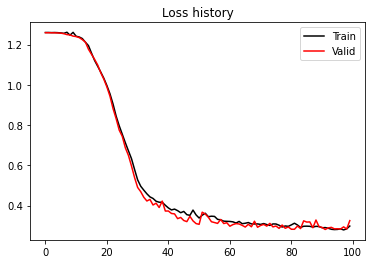

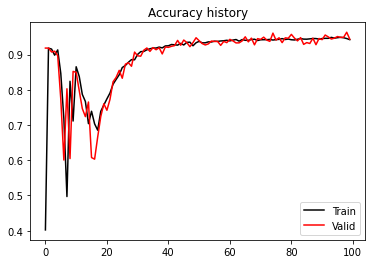

In [22]:
model = 'bilstm_weightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_w2 = BiLSTMNetwork(1, 200, 1)
    network_w2.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_w2.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_w2, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network_w2 = BiLSTMNetwork(1, 200, 1)
network_w2.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network_w2.to(device)
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

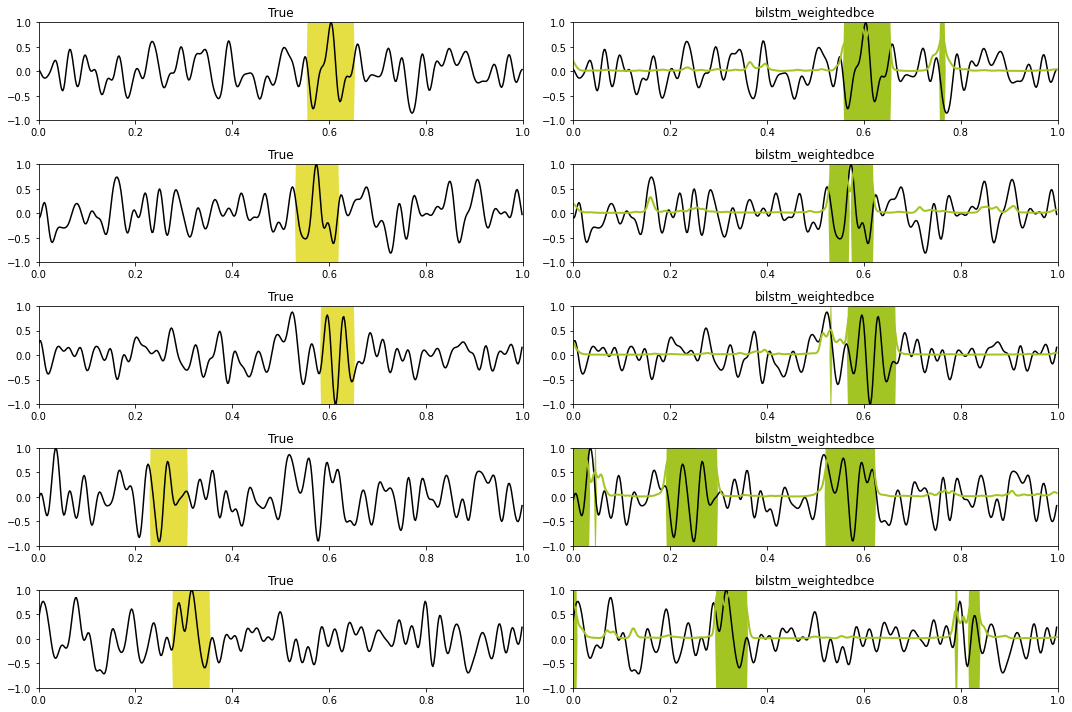

In [23]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_w2, X, y, model, device, dt=dt, nplot=5)

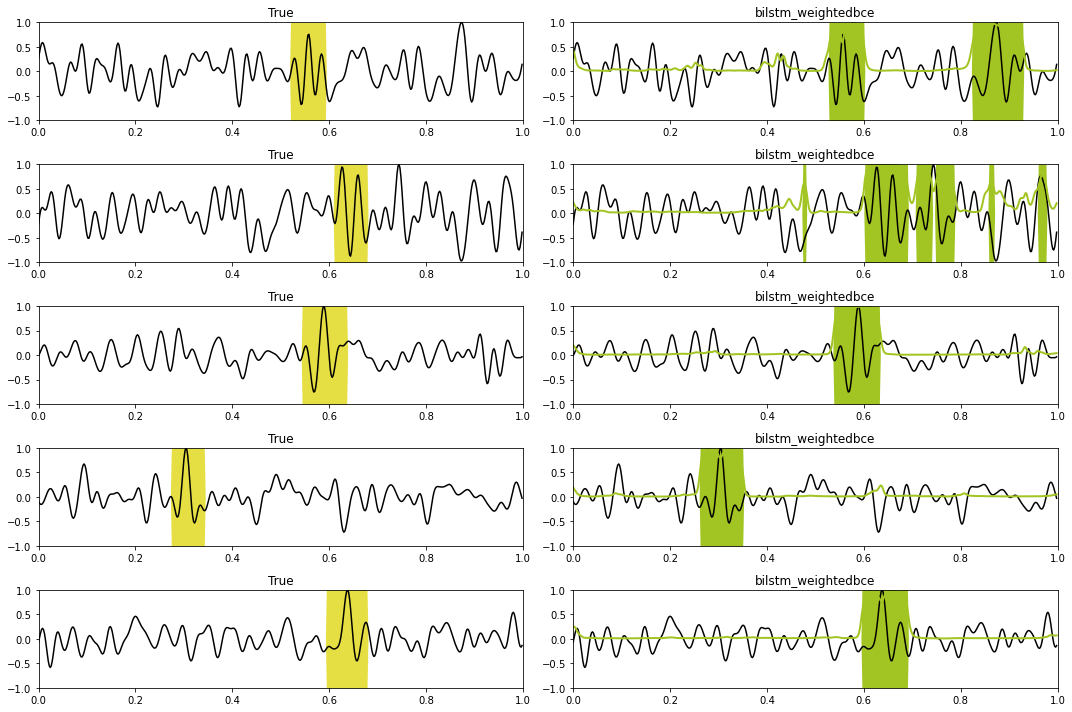

In [24]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_w2, X, y, model, device, dt=dt, nplot=5)

### Double BidirLSTM

In [25]:
model = 'doublelstm_weightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_st = DoubleBiLSTMNetwork(1, 200, 100, 1)
    network_st.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_st.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_st, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network_st = DoubleBiLSTMNetwork(1, 200, 100, 1)
network_st.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network_st.to(device)
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

Epoch 0, Training Loss 1.260, Training Accuracy 0.914, Test Loss 1.259, Test Accuracy 0.919
Epoch 10, Training Loss 0.907, Training Accuracy 0.860, Test Loss 0.814, Test Accuracy 0.852


KeyboardInterrupt: 

In [ ]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_st, X, y, model, device, dt=dt, nplot=5)

In [ ]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_st, X, y, model, device, dt=dt, nplot=5)